In [3]:
from cloud_utils.utils import get_gcs_data, get_client, get_time_dates, gcs_load_name, get_data
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt

## Generate Dataset

In [4]:
bucket = "ml-energy-dashboard-raw-data"
folder = 'raw-days'
client = get_client()

In [5]:
dates = get_time_dates(90, pairs=True)
data = get_data(client, dates)

raw-days/es-energy-demand-20191220T2300-20191221T2300
raw-days/es-energy-demand-20191221T2300-20191222T2300
raw-days/es-energy-demand-20191222T2300-20191223T2300
raw-days/es-energy-demand-20191223T2300-20191224T2300
raw-days/es-energy-demand-20191224T2300-20191225T2300
raw-days/es-energy-demand-20191225T2300-20191226T2300
raw-days/es-energy-demand-20191226T2300-20191227T2300
raw-days/es-energy-demand-20191227T2300-20191228T2300
raw-days/es-energy-demand-20191228T2300-20191229T2300
raw-days/es-energy-demand-20191229T2300-20191230T2300
raw-days/es-energy-demand-20191230T2300-20191231T2300
raw-days/es-energy-demand-20191231T2300-20200101T2300
raw-days/es-energy-demand-20200101T2300-20200102T2300
raw-days/es-energy-demand-20200102T2300-20200103T2300
raw-days/es-energy-demand-20200103T2300-20200104T2300
raw-days/es-energy-demand-20200104T2300-20200105T2300
raw-days/es-energy-demand-20200105T2300-20200106T2300
raw-days/es-energy-demand-20200106T2300-20200107T2300
raw-days/es-energy-demand-20

Allocate train and test sets.
Train set 75 days. 
Test set 15 days.

In [9]:
def load_data():
    
    path = '~/github-repos/energy-dashboard/data'
    bucket = "ml-energy-dashboard-raw-data"
    folder = 'raw-days'
    period = 90 #days
    
    try:
        train = pd.read_csv(os.path.join(path, 'train-20191219-20200302.csv'), index_col=[0], parse_dates=True)
        print('Train data loaded from local')
        
        test = pd.read_csv(os.path.join(path, 'test-20200103-20200317.csv'), index_col=[0], parse_dates=True)
        print('Test data loaded from local')
        
        print(f'Train date start {train.index.min()} end {train.index.max()}')
        print(f'Test date start {test.index.min()} end {test.index.max()}')
        
    except:
        print('Downloading data sets from cloud...')
        
        client = get_client()
        
        dates = get_time_dates(period, pairs=True)
        data = get_data(client, dates)
        
        train_days = 75
        test_days = 15
        
        train = data[:train_days*24]
        test = data[-test_days*24:]
        
        print(f'Train date start {train.index.min()} end {train.index.max()}')
        print(f'Test date start {test.index.min()} end {test.index.max()}')
    
    return train, test

train, test = load_data()

raw-days/es-energy-demand-20191220T2300-20191221T2300
raw-days/es-energy-demand-20191221T2300-20191222T2300
raw-days/es-energy-demand-20191222T2300-20191223T2300
raw-days/es-energy-demand-20191223T2300-20191224T2300
raw-days/es-energy-demand-20191224T2300-20191225T2300
raw-days/es-energy-demand-20191225T2300-20191226T2300
raw-days/es-energy-demand-20191226T2300-20191227T2300
raw-days/es-energy-demand-20191227T2300-20191228T2300
raw-days/es-energy-demand-20191228T2300-20191229T2300
raw-days/es-energy-demand-20191229T2300-20191230T2300
raw-days/es-energy-demand-20191230T2300-20191231T2300
raw-days/es-energy-demand-20191231T2300-20200101T2300
raw-days/es-energy-demand-20200101T2300-20200102T2300
raw-days/es-energy-demand-20200102T2300-20200103T2300
raw-days/es-energy-demand-20200103T2300-20200104T2300
raw-days/es-energy-demand-20200104T2300-20200105T2300
raw-days/es-energy-demand-20200105T2300-20200106T2300
raw-days/es-energy-demand-20200106T2300-20200107T2300
raw-days/es-energy-demand-20

In [10]:
path = "~/github-repos/energy-dashboard/data"
train.to_csv(os.path.join(path, f'train-{train.index.min()}-{train.index.max()}'))
test.to_csv(os.path.join(path, f'test-{test.index.min()}-{test.index.max()}'))

## Preprocessing Pipeline

In [11]:
def transform_hours(series):
    df = pd.DataFrame()

    df['year'] = series.index.year
    df['month'] = series.index.month
    df['day'] = series.index.day
    df['hours'] = series.index.hour
    df['loads'] = series.values

    date_list = pd.to_datetime(df.loc[:,['year', 'month', 'day']], format='%Y-%m-%d', errors='ignore')
    df = df.set_index(pd.DatetimeIndex(date_list, name='date'))
    df = df.drop(['year', 'month', 'day'], axis=1)
    df = df.drop_duplicates()
    df = df.pivot(columns='hours', values='loads')
    
    return df

train_df = transform_hours(train)
train_df

hours,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2019-12-21,25221.0,23305.0,21976.0,21194.0,20862.0,20930.0,21758.0,23135.0,24656.0,27007.0,...,28329.0,27192.0,26632.0,26859.0,28321.0,28752.0,29107.0,28826.0,27403.0,25465.0
2019-12-22,23435.0,21641.0,20456.0,19757.0,19414.0,19342.0,19787.0,20774.0,21922.0,23931.0,...,26289.0,25002.0,24205.0,24454.0,26399.0,27170.0,27988.0,28158.0,26958.0,24821.0
2019-12-23,22716.0,21058.0,20024.0,19359.0,19278.0,20099.0,22218.0,25172.0,27565.0,29428.0,...,28871.0,28028.0,27722.0,27978.0,29534.0,29733.0,29892.0,29686.0,28012.0,25543.0
2019-12-24,23251.0,21201.0,19813.0,19110.0,18860.0,19227.0,20710.0,22954.0,24950.0,27041.0,...,25952.0,24931.0,24392.0,24867.0,27122.0,27364.0,26361.0,24681.0,22504.0,21541.0
2019-12-25,20946.0,19931.0,18740.0,17726.0,17208.0,17185.0,17491.0,18040.0,18269.0,19573.0,...,22080.0,20550.0,20088.0,20603.0,22832.0,23844.0,24680.0,24974.0,24339.0,22394.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29,26178.0,24712.0,23324.0,22717.0,22428.0,22310.0,22895.0,23909.0,25274.0,27946.0,...,28673.0,27383.0,26595.0,26376.0,26731.0,28763.0,29649.0,29607.0,28193.0,26209.0
2020-03-01,24306.0,22848.0,21638.0,20833.0,20431.0,20616.0,21035.0,21434.0,22076.0,24313.0,...,26791.0,25465.0,24576.0,24265.0,25052.0,27950.0,29592.0,29384.0,28285.0,26502.0
2020-03-02,24359.0,22644.0,21709.0,21432.0,21573.0,22336.0,25463.0,29200.0,31353.0,32759.0,...,32143.0,31420.0,30818.0,30579.0,30885.0,33246.0,34548.0,33501.0,30950.0,28059.0


In [12]:
#fill nans
def fill_nans(df):
    return df.interpolate(method='linear', axis=0)
train_df = fill_nans(train_df)

In [13]:
def normalize_df(df, test=None, scaler=None):
    
    if test:
        data_normd = scaler.transform(df)
    else:
        #normalize the dataset for working with the lstm nn
        scaler = MinMaxScaler().fit(df.values)
        data_normd = scaler.transform(df.values)
    
    #return as dataframe
    df = pd.DataFrame(data_normd, index=df.index, columns=df.columns)
    
    return df, scaler

train_df, scaler = normalize_df(train_df)
train_df

hours,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2019-12-21,0.571769,0.571211,0.539372,0.500783,0.476891,0.442253,0.388227,0.323718,0.340078,0.393687,...,0.381246,0.384064,0.374285,0.368108,0.344440,0.305871,0.286407,0.296325,0.375345,0.389093
2019-12-22,0.358846,0.360365,0.339556,0.313283,0.289956,0.254724,0.208898,0.173709,0.194505,0.230790,...,0.256787,0.257430,0.235472,0.226596,0.223833,0.207279,0.214013,0.248570,0.341250,0.325235
2019-12-23,0.273128,0.286493,0.282766,0.261352,0.272399,0.344119,0.430079,0.453142,0.494968,0.521898,...,0.414313,0.432404,0.436628,0.433951,0.420557,0.367007,0.337194,0.357807,0.422004,0.396827
2019-12-24,0.336910,0.304612,0.255028,0.228862,0.218435,0.241143,0.292876,0.312218,0.355732,0.395488,...,0.236227,0.253325,0.246168,0.250897,0.269202,0.219369,0.108753,0.000000,0.000000,0.000000
2019-12-25,0.062113,0.143690,0.113974,0.048278,0.005164,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020947,0.140591,0.084581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29,0.685861,0.749493,0.716577,0.699504,0.679060,0.605220,0.491675,0.372895,0.372983,0.443415,...,0.402233,0.395108,0.372169,0.339688,0.244666,0.306556,0.321472,0.352159,0.435872,0.462866
2020-03-01,0.462685,0.513305,0.494939,0.453680,0.421250,0.405172,0.322446,0.215643,0.202705,0.251019,...,0.287414,0.284203,0.256692,0.215475,0.139307,0.255889,0.317785,0.336217,0.442921,0.491919
2020-03-02,0.469003,0.487456,0.504272,0.531837,0.568681,0.608290,0.725321,0.709067,0.696662,0.698300,...,0.613934,0.628542,0.613704,0.586996,0.505334,0.585940,0.638416,0.630540,0.647104,0.646306


In [14]:
def split_sequences(sequences, n_steps, extra_lag=False, long_lag_step=7, max_step=30, idx=0, multivar=False):
    """
    Modified based on content by Jason Brownlee from MachineLearningMastery.
    
    n_step - is the number of consecutive past steps from the target day to construct
    long_lag_step - is the size of the trailing lag beyond the n_steps. Ie. if n_steps is 3, and long_lag_step is 7 will return day -1, -2, -3, -7, -14 etc to max_step
    idx - is the starting index for the first slice
    multivari - true if the input data has multiple variable structure. false for univariate
    """
    
    #if not adding extra lag features adjust max_step and n_steps to aling
    if not extra_lag:
        max_step=n_steps
        n_steps+=1
        
    
    X, y = list(), list()
    for i in range(len(sequences)):
        
        # find the end of this pattern
        #end_ix = i + n_steps
        end_ix = i + max_step
        
        #create a list with the indexes we want to include in each sample
        slices = [x for x in range(end_ix-1,end_ix-n_steps, -1)] + [y for y in range(end_ix-n_steps, i, -long_lag_step)]
        
        #reverse the slice indexes
        slices = list(reversed(slices))
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break


        # gather input and output parts of the pattern
        seq_x = sequences[slices, :]
        seq_y = sequences[end_ix, :]

        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    
    if multivar:
        #unstack the 3rd dimension and select the first element(energy load)
        y = y[:,idx]
    
    return X, y

n_steps = 7
long_lag_step = 7

X_train, Y_train = split_sequences(train_df.values, 
                       n_steps, 
                       extra_lag=True, 
                       long_lag_step=long_lag_step, 
                       max_step=30, 
                       idx=0, 
                       multivar=False)
print(f'Transformed train dataset shape {train_df.shape}')
print(f'X_train shape. No sample days {X_train.shape[0]} No features {X_train.shape[1]} No hours {X_train.shape[2]}')
print(f'Y_train shape. No sample days {Y_train.shape[0]} No target values {X_train.shape[1]}')
X_train[:1], Y_train[:1]

Transformed train dataset shape (75, 24)
X_train shape. No sample days 45 No features 10 No hours 24
Y_train shape. No sample days 45 No target values 10


(array([[[0.27312828, 0.28649265, 0.28276587, 0.26135177, 0.27239866,
          0.34411904, 0.43007916, 0.45314188, 0.49496832, 0.521898  ,
          0.47167108, 0.41790958, 0.38177951, 0.39127363, 0.41431273,
          0.4324043 , 0.43662777, 0.43395116, 0.42055723, 0.36700735,
          0.3371935 , 0.35780669, 0.42200429, 0.39682697],
         [0.33619456, 0.31512924, 0.30866307, 0.29527662, 0.31319391,
          0.35085026, 0.41488491, 0.43973569, 0.49305149, 0.55160727,
          0.52645503, 0.48153111, 0.44015125, 0.45280575, 0.47288146,
          0.4756563 , 0.47374743, 0.47431598, 0.48067269, 0.45070423,
          0.42783205, 0.45724907, 0.51930739, 0.51284085],
         [0.57141154, 0.55410542, 0.48376495, 0.43606472, 0.41053447,
          0.39230043, 0.3281776 , 0.24645784, 0.22272509, 0.25048986,
          0.2545194 , 0.24446516, 0.2128087 , 0.22540187, 0.24928314,
          0.25349832, 0.25714939, 0.26084142, 0.28187751, 0.31422161,
          0.33156499, 0.39919931, 0.534247

In [64]:
def process_pipeline(series, test_df=False, scaler=None, train_df=None):
    
    max_step = 30
    
    df = transform_hours(series)
    df = fill_nans(df)
    
    dataset='train'
    
    if test_df:
        assert scaler is not None, 'must pass in minmax scaler object when test is True'
        assert train_df is not None, 'must pass train set to make test samples'
        
        df, scaler = normalize_df(df, test=True, scaler=scaler)
        
        #append the last days acording to max_step from train set to make predictions
        train_df = transform_hours(train_df)
        train_df = fill_nans(train_df)
        train_df, _ = normalize_df(train_df, test=True, scaler=scaler)
        
        df = pd.concat([train_df[-max_step:], df], axis=0)
        
        dataset='test'
    else:
        df, scaler = normalize_df(df)
    
    X, Y = split_sequences(df.values, 
                       n_steps, 
                       extra_lag=True, 
                       long_lag_step=long_lag_step, 
                       max_step=30, 
                       idx=0, 
                       multivar=False)
    print(X.shape)
    print(Y.shape)
    print(f'Transformed {dataset} dataset shape {df.shape}')
    print(f'X_{dataset} shape. No sample days {X.shape[0]} No features {X.shape[1]} No hours {X.shape[2]}')
    print(f'Y_{dataset} shape. No sample days {Y.shape[0]} No target values {X.shape[1]}')
    
    return X, Y, scaler

X_train, Y_train, scaler = process_pipeline(train)

(45, 10, 24)
(45, 24)
Transformed train dataset shape (75, 24)
X_train shape. No sample days 45 No features 10 No hours 24
Y_train shape. No sample days 45 No target values 10


In [43]:
X_train, Y_train, scaler = process_pipeline(train)

(45, 10, 24)
(45, 24)
Transformed train dataset shape (75, 24)
X_train shape. No sample days 45 No features 10 No hours 24
Y_train shape. No sample days 45 No target values 10


In [41]:
X_test, Y_test, scaler = process_pipeline(test, test_df=True, scaler=scaler, train_df=train)

(15, 10, 24)
(15, 24)
Transformed test dataset shape (45, 24)
X_test shape. No sample days 15 No features 10 No hours 24
Y_test shape. No sample days 15 No target values 10


## Define LSTM model

In [44]:
def lstm_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dense(n_hours))
    model.add(keras.layers.Dropout(0.2))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

lstm_model = lstm_parallel_out(X_train.shape[1], X_train.shape[-1])
lstm_model.fit(X_train, Y_train, epochs=200, verbose=1)

Train on 45 samples
Epoch 1/200
45/45 [==============================] - 2s 41ms/sample - loss: 0.6608
Epoch 2/200
45/45 [==============================] - 0s 747us/sample - loss: 0.5528
Epoch 3/200
45/45 [==============================] - 0s 756us/sample - loss: 0.4785
Epoch 4/200
45/45 [==============================] - 0s 731us/sample - loss: 0.4293
Epoch 5/200
45/45 [==============================] - 0s 731us/sample - loss: 0.3900
Epoch 6/200
45/45 [==============================] - 0s 726us/sample - loss: 0.3475
Epoch 7/200
45/45 [==============================] - 0s 720us/sample - loss: 0.3335
Epoch 8/200
45/45 [==============================] - 0s 698us/sample - loss: 0.2966
Epoch 9/200
45/45 [==============================] - 0s 698us/sample - loss: 0.2853
Epoch 10/200
45/45 [==============================] - 0s 728us/sample - loss: 0.2535
Epoch 11/200
45/45 [==============================] - 0s 719us/sample - loss: 0.2358
Epoch 12/200
45/45 [==============================] - 0

45/45 [==============================] - 0s 593us/sample - loss: 0.1747
Epoch 98/200
45/45 [==============================] - 0s 614us/sample - loss: 0.1723
Epoch 99/200
45/45 [==============================] - 0s 612us/sample - loss: 0.1647
Epoch 100/200
45/45 [==============================] - 0s 585us/sample - loss: 0.1622
Epoch 101/200
45/45 [==============================] - 0s 615us/sample - loss: 0.1718
Epoch 102/200
45/45 [==============================] - 0s 618us/sample - loss: 0.1728
Epoch 103/200
45/45 [==============================] - 0s 662us/sample - loss: 0.1762
Epoch 104/200
45/45 [==============================] - 0s 652us/sample - loss: 0.1708
Epoch 105/200
45/45 [==============================] - 0s 562us/sample - loss: 0.1792
Epoch 106/200
45/45 [==============================] - 0s 570us/sample - loss: 0.1611
Epoch 107/200
45/45 [==============================] - 0s 561us/sample - loss: 0.1553
Epoch 108/200
45/45 [==============================] - 0s 551us/sample

45/45 [==============================] - 0s 587us/sample - loss: 0.1547
Epoch 193/200
45/45 [==============================] - 0s 556us/sample - loss: 0.1574
Epoch 194/200
45/45 [==============================] - 0s 521us/sample - loss: 0.1620
Epoch 195/200
45/45 [==============================] - 0s 557us/sample - loss: 0.1575
Epoch 196/200
45/45 [==============================] - 0s 524us/sample - loss: 0.1719
Epoch 197/200
45/45 [==============================] - 0s 554us/sample - loss: 0.1546
Epoch 198/200
45/45 [==============================] - 0s 535us/sample - loss: 0.1513
Epoch 199/200
45/45 [==============================] - 0s 539us/sample - loss: 0.1485
Epoch 200/200
45/45 [==============================] - 0s 549us/sample - loss: 0.1526


## Evaluate Model

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [101]:
def plot_hourly_error(Y_true, Y_preds):
    #calcuate the hourly errors
    hourly_errors = [mean_absolute_percentage_error(Y_true[:, hour], Y_preds[:, hour]) for hour in range(Y_true.shape[1])]

    hourly_errors = pd.Series(hourly_errors)

    print(mean_absolute_percentage_error(Y_true, Y_preds))
    
    hourly_errors.plot()
    plt.xlabel('Hour of the Day')
    plt.ylabel('MAPE %')
    

45/45 [==============================] - 0s 252us/sample
18.098463677913017


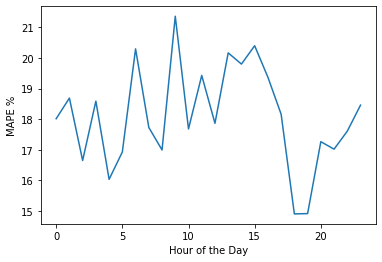

In [102]:
#make training predictions
y_train_preds = lstm_model.predict(X_train, verbose=1)

plot_hourly_error(Y_train, y_train_preds)

## Make predictions on the test set

In [65]:
X_test, Y_test, scaler = process_pipeline(test, test_df=True, scaler=scaler, train_df=train)

(15, 10, 24)
(15, 24)
Transformed test dataset shape (45, 24)
X_test shape. No sample days 15 No features 10 No hours 24
Y_test shape. No sample days 15 No target values 10


In [66]:
y_test_preds = lstm_model.predict(X_test)

print(y_test_preds.shape)
print(Y_test.shape)

(15, 24)
(15, 24)


20.118727693105694


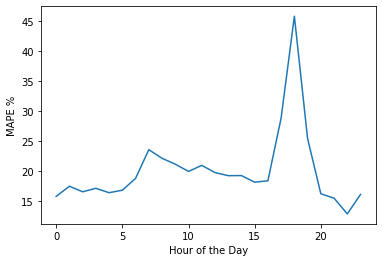

In [103]:
plot_hourly_error(Y_test, y_test_preds)

In [109]:
!pwd

/Users/ns/github-repos/energy-dashboard


In [111]:
lstm_model.save('/Users/ns/github-repos/energy-dashboard/models/v1_univar_20200321.h5')
lstm_model.save_weights('/Users/ns/github-repos/energy-dashboard/models/v1_univar_20200321_weights')

## Reload weights and check

In [113]:
lstm_loaded = keras.models.load_model('/Users/ns/github-repos/energy-dashboard/models/v1_univar_20200321.h5')

In [114]:
lstm_loaded.predict(X_test)

array([[0.5986333 , 0.61955476, 0.6348251 , 0.6340549 , 0.65972286,
        0.6609172 , 0.6488169 , 0.6383128 , 0.6192453 , 0.5984604 ,
        0.54356545, 0.5155545 , 0.49454334, 0.48440376, 0.49997777,
        0.50092065, 0.5041822 , 0.47743905, 0.44434476, 0.5205819 ,
        0.5159808 , 0.52809286, 0.54427576, 0.5530419 ],
       [0.60016346, 0.6183244 , 0.6321345 , 0.6323919 , 0.6586227 ,
        0.65804744, 0.6413173 , 0.6240203 , 0.60589767, 0.59083855,
        0.53409106, 0.5091279 , 0.48700067, 0.47568518, 0.4941368 ,
        0.49291235, 0.4973914 , 0.46910948, 0.4348495 , 0.51312107,
        0.50695163, 0.51941115, 0.5376677 , 0.5463103 ],
       [0.5844096 , 0.6012949 , 0.57278305, 0.55816853, 0.5497729 ,
        0.497312  , 0.37233597, 0.30421585, 0.29776803, 0.30782473,
        0.32214785, 0.29914394, 0.28801492, 0.27164537, 0.29297328,
        0.28799015, 0.28505695, 0.25627714, 0.20868808, 0.2772186 ,
        0.2965138 , 0.32910556, 0.4007613 , 0.43063587],
       [0.415